In [6]:
import typing
import os.path as op
import anaconfig

from tqdm.auto import tqdm
from joblib import Parallel, delayed
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt
import montetracko.lhcb as mtb

from utils.loaderutils.preprocessing import load_dataframes
from utils.plotutils.plotconfig import configure_matplotlib
from utils.plotutils.plotools import save_fig
from Processing.planewise_edges import get_planewise_edges


configure_matplotlib()

In [7]:
plotdir = op.join(anaconfig.PLOTDIR, "scifi")

In [8]:
df_hits_particles, df_particles = load_dataframes(
    indir="/scratch/acorreia/minbias-sim10b-xdigi/2/",
    particles_filename="mc_particles",
    hits_particles_filename="hits_scifi",
)
df_hits_particles["fake"] = df_hits_particles["particle_id"] == 0


# Add hit number within particle
df_hits_particles = df_hits_particles.merge(
    df_hits_particles.groupby("particle_id")["plane"]
    .min()
    .rename("min_plane")
    .reset_index(),
    how="left",
    on="particle_id",
)
df_hits_particles = df_hits_particles.merge(
    df_hits_particles.groupby("particle_id")["plane"]
    .max()
    .rename("max_plane")
    .reset_index(),
    how="left",
    on="particle_id",
)


# Hits-related distributions


## Number of hits

Figure was saved in /home/acorreia/Documents/tracking/etx4velo/etx4velo/output/preliminary/scifi/n_hits_per_event.pdf
Figure was saved in /home/acorreia/Documents/tracking/etx4velo/etx4velo/output/preliminary/scifi/n_hits_per_event.png


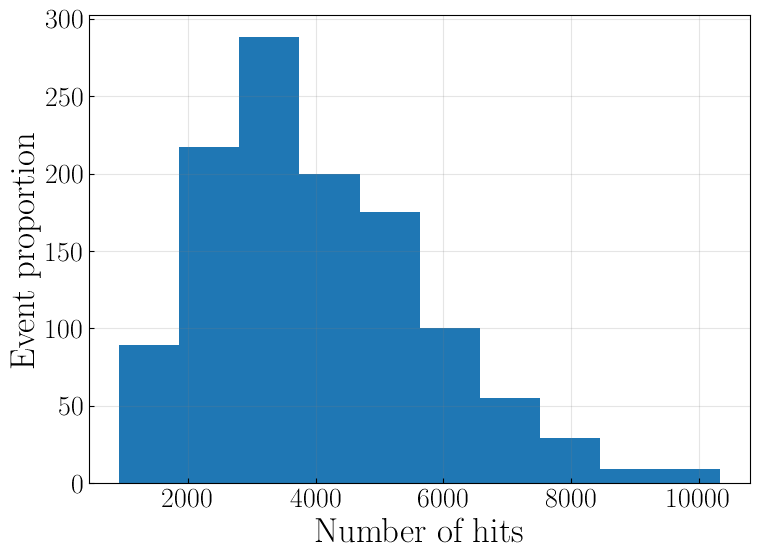

In [6]:
df_hits = df_hits_particles[["event_id", "hit_id", "plane", "fake"]].drop_duplicates(
    ["event_id", "hit_id"]
)
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df_hits.groupby(by=["event_id"])["hit_id"].count())
ax.grid(color="grey", alpha=0.2)
ax.set_xlabel("Number of hits")
ax.set_ylabel("Event proportion")
save_fig(fig, op.join(plotdir, "n_hits_per_event"))

## Proportion of fake hits

Figure was saved in /home/acorreia/Documents/tracking/etx4velo/etx4velo/output/preliminary/scifi/n_hits_per_event.pdf
Figure was saved in /home/acorreia/Documents/tracking/etx4velo/etx4velo/output/preliminary/scifi/n_hits_per_event.png


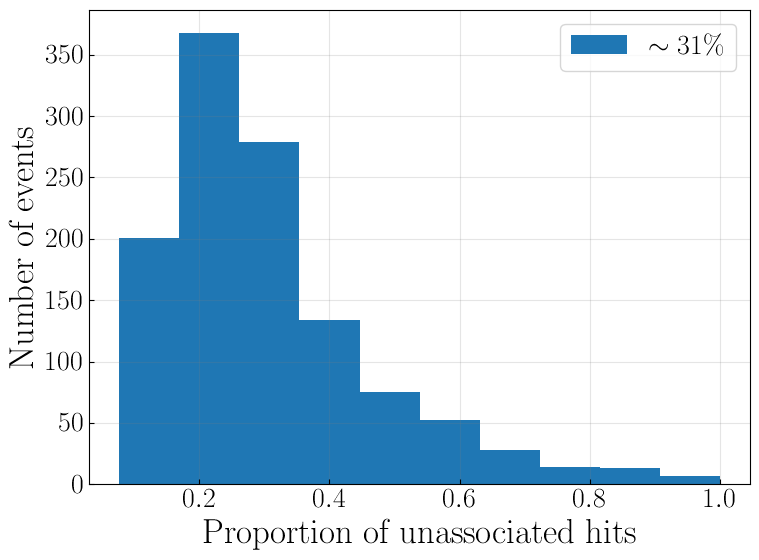

In [12]:
event_ids = df_hits_particles["event_id"].unique()
n_fake_per_event = (
    df_hits[df_hits["fake"]]
    .groupby("event_id")["hit_id"]
    .count()
    .reindex(event_ids, fill_value=0)
)

n_genuine_per_event = (
    df_hits[~df_hits["fake"]]
    .groupby("event_id")["hit_id"]
    .count()
    .reindex(event_ids, fill_value=0)
)
fig, ax = plt.subplots(figsize=(8, 6))
prop_fake_hits = n_fake_per_event / (n_genuine_per_event + n_fake_per_event)
ax.hist(prop_fake_hits, label=f"$\\sim {prop_fake_hits.mean()*100:.0f}\\%$")
ax.legend()
ax.grid(color="grey", alpha=0.2)
ax.set_xlabel("Proportion of unassociated hits")
ax.set_ylabel("Number of events")
save_fig(fig, op.join(plotdir, "n_hits_per_event"))

## Proportion of hits per plane

Figure was saved in /home/acorreia/Documents/tracking/etx4velo/etx4velo/output/preliminary/scifi/n_hits_per_event_per_plane.pdf
Figure was saved in /home/acorreia/Documents/tracking/etx4velo/etx4velo/output/preliminary/scifi/n_hits_per_event_per_plane.png


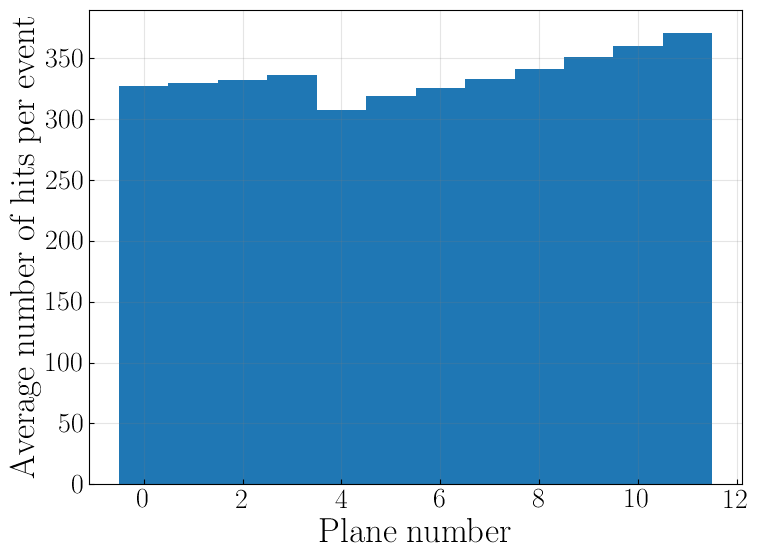

In [56]:
planes = df_hits_particles["plane"].unique()

n_hits_per_plane = (
    df_hits.groupby(["plane", "event_id"])["hit_id"].count().groupby("plane").mean()
)
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(
    x=planes,
    height=n_hits_per_plane,
    width=1.0,
)
ax.set_xlabel("Plane number")
ax.set_ylabel("Average number of hits per event")
ax.locator_params(axis="x", integer=True)
ax.grid(color="grey", alpha=0.2)
save_fig(fig, op.join(plotdir, "n_hits_per_event_per_plane"))

## Proportion of shared hits

Figure was saved in /home/acorreia/Documents/tracking/etx4velo/etx4velo/output/preliminary/scifi/n_shared_per_hit.pdf
Figure was saved in /home/acorreia/Documents/tracking/etx4velo/etx4velo/output/preliminary/scifi/n_shared_per_hit.png


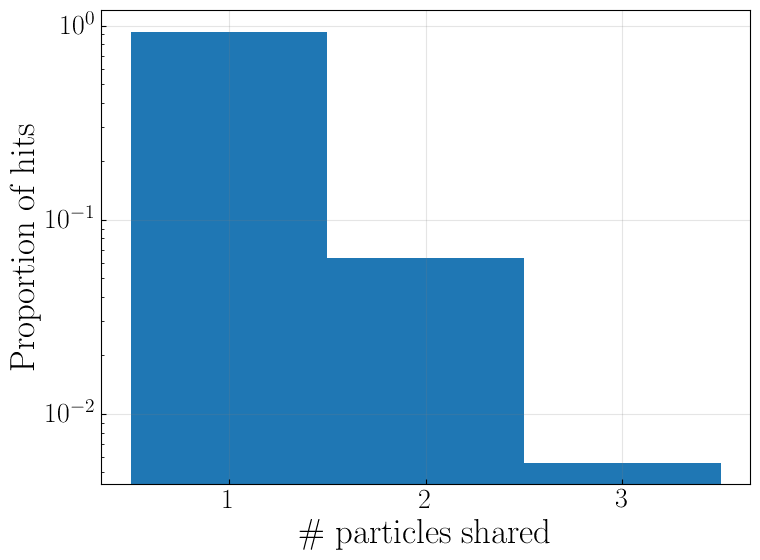

In [57]:
fig, ax = plt.subplots(figsize=(8, 6))

n_particles_shared_max = 3

hist_n_shared_per_hit, _ = np.histogram(
    (
        df_hits_particles[~df_hits_particles["fake"]]
        .groupby(["event_id", "hit_id"])["particle_id"]
        .count()
    ),
    bins=np.arange(1, n_particles_shared_max + 2) - 0.5,
)

ax.bar(
    x=np.arange(1, n_particles_shared_max + 1),
    height=hist_n_shared_per_hit / hist_n_shared_per_hit.sum(),
    width=1.0,
)
ax.set_yscale("log")
ax.set_xlabel("\\# particles shared")
ax.set_ylabel("Proportion of hits")
ax.locator_params(axis="x", integer=True)
ax.grid(color="grey", alpha=0.2)
save_fig(fig, op.join(plotdir, "n_shared_per_hit"))

In [214]:
df_hits_particles_weight = (
    df_hits_particles[~df_hits_particles["fake"]][["event_id", "hit_id", "weight"]]
    .drop_duplicates(["event_id", "hit_id"])
    .merge(
        (
            df_hits_particles[~df_hits_particles["fake"]]
            .groupby(["event_id", "hit_id"])["particle_id"]
            .count()
            .rename("n_shared_particles")
            .reset_index()
        ),
        on=["event_id", "hit_id"],
        how="left",
    )
)

In [218]:
df_hits_particles_weight["weight"].unique()

array([ 34.6021, 400.    ,  25.    ,  14.7929,  18.9036,  11.8906])

Text(0, 0.5, '\\# shared particles')

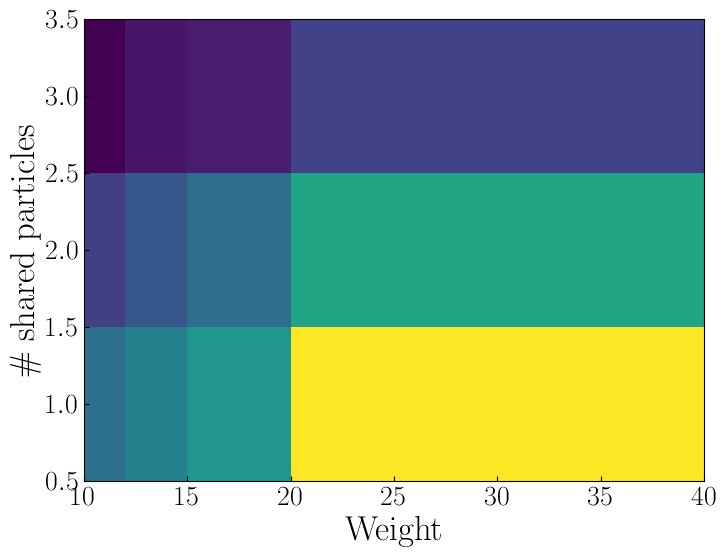

In [222]:
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist2d(
    x=df_hits_particles_weight["weight"],
    y=df_hits_particles_weight["n_shared_particles"],
    bins=[[10, 12, 15, 20, 40], np.arange(1, 5) - 0.5],
    norm=mpl.colors.LogNorm(),
)
ax.set_xlabel("Weight")
ax.set_ylabel("\\# shared particles")


# Particles-related distributions

## Number of particles per event


Figure was saved in /home/acorreia/Documents/tracking/etx4velo/etx4velo/output/preliminary/scifi/n_particles_per_event.pdf
Figure was saved in /home/acorreia/Documents/tracking/etx4velo/etx4velo/output/preliminary/scifi/n_particles_per_event.png


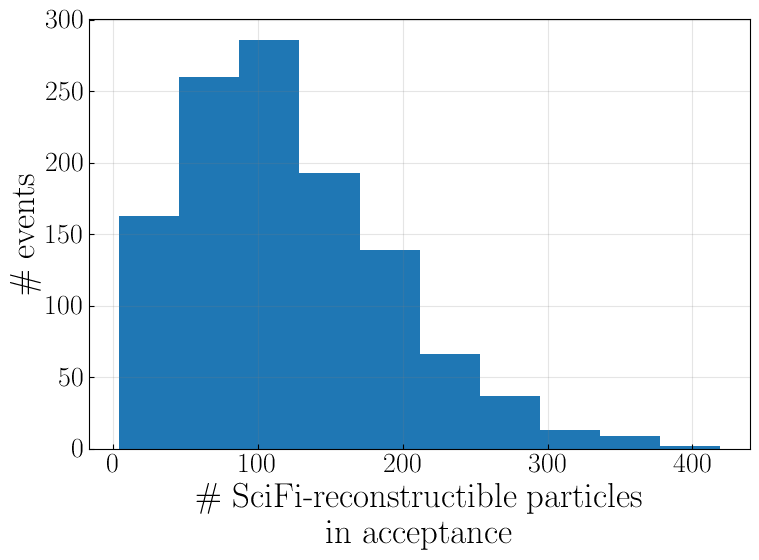

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(
    df_particles[
        df_particles["has_scifi"] & mtb.category.in_acceptance.mask(df_particles)
    ]
    .groupby("event_id")["particle_id"]
    .count()
)
ax.grid(color="grey", alpha=0.2)
ax.set_xlabel("\\# SciFi-reconstructible particles\nin acceptance")
ax.set_ylabel("\\# events")
save_fig(fig, op.join(plotdir, "n_particles_per_event"))


## Particle lengths

In [16]:
df_hits_particles_genuine = df_hits_particles[~df_hits_particles["fake"]].merge(
    df_particles[["event_id", "particle_id", "has_scifi", "eta", "mother_pid"]],
    how="left",
    on=["event_id", "particle_id"],
)

df_hits_particles_genuine_in_cat = df_hits_particles_genuine[
    df_hits_particles_genuine["has_scifi"]
    & mtb.category.in_acceptance.mask(df_hits_particles_genuine)
]

Figure was saved in /home/acorreia/Documents/tracking/etx4velo/etx4velo/output/preliminary/scifi/particle_length_in_cat.pdf
Figure was saved in /home/acorreia/Documents/tracking/etx4velo/etx4velo/output/preliminary/scifi/particle_length_in_cat.png


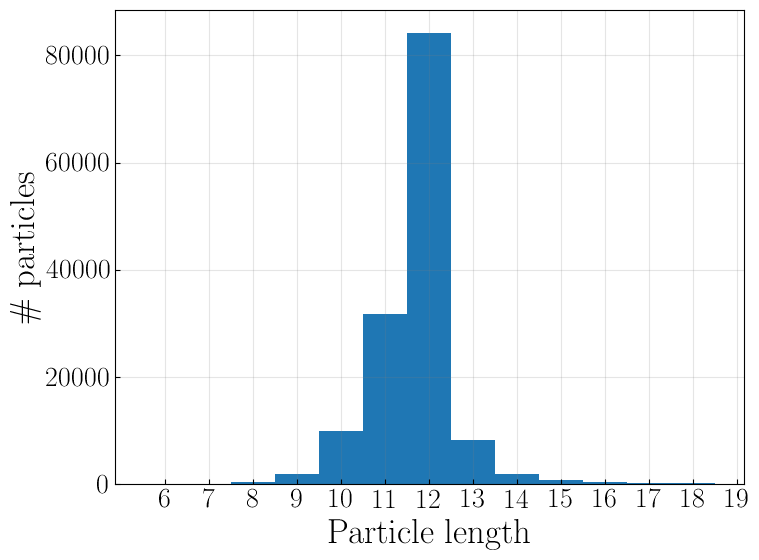

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(
    (
        df_hits_particles_genuine_in_cat.groupby(["event_id", "particle_id"])[
            "hit_id"
        ].count()
    ),
    bins=np.arange(6, 20) - 0.5,
)
ax.set_xticks(np.arange(6, 20))
ax.set_xlabel("Particle length")
ax.set_ylabel("\\# particles")
ax.grid(color="grey", alpha=0.2)

save_fig(fig, op.join(plotdir, "particle_length_in_cat"))

Figure was saved in /home/acorreia/Documents/tracking/etx4velo/etx4velo/output/preliminary/scifi/particle_length_reconstructible.pdf
Figure was saved in /home/acorreia/Documents/tracking/etx4velo/etx4velo/output/preliminary/scifi/particle_length_reconstructible.png


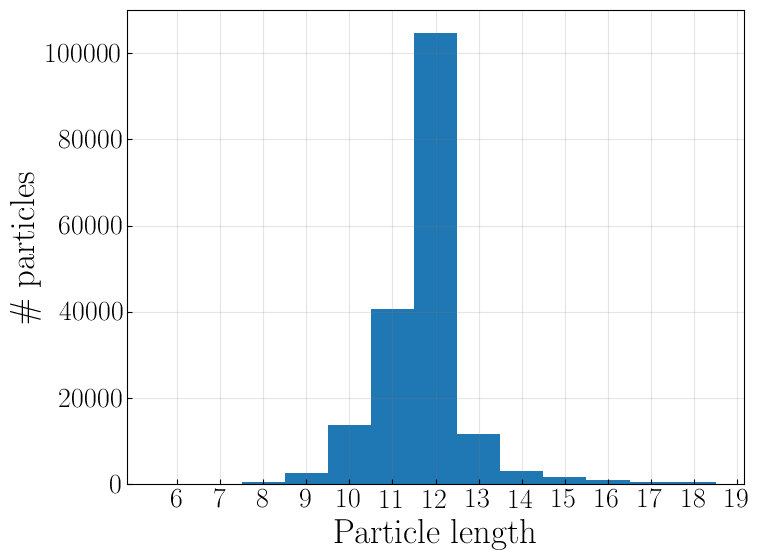

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(
    (
        df_hits_particles_genuine[df_hits_particles_genuine["has_scifi"]]
        .groupby(["event_id", "particle_id"])["hit_id"]
        .count()
    ),
    bins=np.arange(6, 20) - 0.5,
)
ax.set_xticks(np.arange(6, 20))
ax.set_xlabel("Particle length")
ax.set_ylabel("\\# particles")
ax.grid(color="grey", alpha=0.2)

save_fig(fig, op.join(plotdir, "particle_length_reconstructible"))

In [18]:
df_hits_particles_scifi = df_hits_particles_genuine[
    df_hits_particles_genuine["has_scifi"]
]


In [42]:
def plot_n_shared_hits_per_particle(
    df_hits_particles: pd.DataFrame, title: str | None = None, suffix: str = ""
):
    df_hits_particles_augmented = df_hits_particles.merge(
        (
            (
                (
                    df_hits_particles.groupby(["event_id", "hit_id"])[
                        "particle_id"
                    ].count()
                )
                > 1
            )
            .rename("shared")
            .reset_index()
        ),
        how="left",
        on=["event_id", "hit_id"],
    )
    fig, ax = plt.subplots(figsize=(8, 6))

    max_n_shared = 6

    hist_n_shared_hits_per_particle, _ = np.histogram(
        df_hits_particles_augmented.groupby(["event_id", "particle_id"])[
            "shared"
        ].sum(),
        bins=np.arange(max_n_shared + 2) - 0.5,
    )

    ax.bar(
        x=np.arange(max_n_shared + 1),
        height=hist_n_shared_hits_per_particle / hist_n_shared_hits_per_particle.sum(),
        width=1.0,
    )
    print(hist_n_shared_hits_per_particle / hist_n_shared_hits_per_particle.sum())
    ax.set_xticks(np.arange(max_n_shared + 1))
    ax.set_xlabel("\\# shared hits")
    ax.set_ylabel("Proportion of particles")
    ax.grid(color="grey", alpha=0.2)
    
    if title is not None:
        ax.set_title(title)

    save_fig(fig, op.join(plotdir, f"n_shared_hits_per_particle{suffix}"))

[6.47223820e-01 2.41288710e-01 7.91348004e-02 2.40372666e-02
 6.23477699e-03 1.54094147e-03 5.39684569e-04]
Figure was saved in /home/acorreia/Documents/tracking/etx4velo/etx4velo/output/preliminary/scifi/n_shared_hits_per_particle_scifi_in_acc.pdf
Figure was saved in /home/acorreia/Documents/tracking/etx4velo/etx4velo/output/preliminary/scifi/n_shared_hits_per_particle_scifi_in_acc.png
[6.74312856e-01 2.26986456e-01 7.16121031e-02 2.03042805e-02
 5.16320427e-03 1.15098117e-03 4.70119070e-04]
Figure was saved in /home/acorreia/Documents/tracking/etx4velo/etx4velo/output/preliminary/scifi/n_shared_hits_per_particle_scifi_in_acc_with_mother.pdf
Figure was saved in /home/acorreia/Documents/tracking/etx4velo/etx4velo/output/preliminary/scifi/n_shared_hits_per_particle_scifi_in_acc_with_mother.png


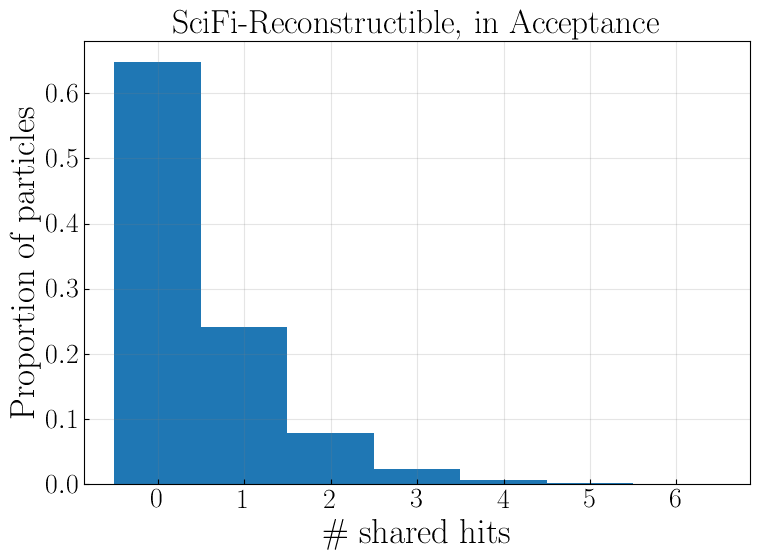

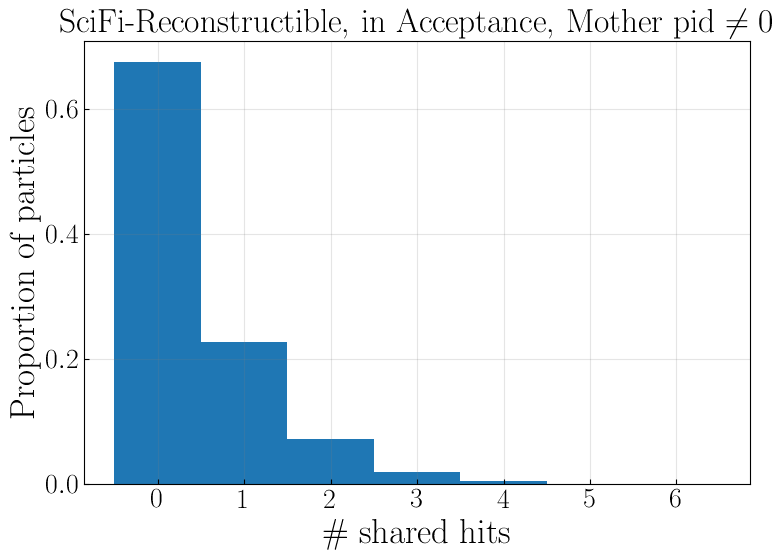

In [47]:
plot_n_shared_hits_per_particle(
    df_hits_particles_genuine_in_cat,
    title="SciFi-Reconstructible, in Acceptance",
    suffix="_scifi_in_acc",
)
plot_n_shared_hits_per_particle(
    df_hits_particles_genuine_in_cat[
        df_hits_particles_genuine_in_cat["mother_pid"] != 0
    ],
    title="SciFi-Reconstructible, in Acceptance, Mother pid $\\neq 0$",
    suffix="_scifi_in_acc_with_mother",
)

In [31]:
if "particle_whose_first_hit_is_shared" not in df_hits_particles_genuine_in_cat:
    df_hits_particles_in_cat_fh = (
        df_hits_particles_genuine_in_cat.merge(
            (
                (
                    (
                        df_hits_particles_genuine_in_cat.groupby(
                            ["event_id", "hit_id"]
                        )["particle_id"].count()
                    )
                    > 1
                )
                .rename("shared")
                .reset_index()
            ),
            how="left",
            on=["event_id", "hit_id"],
        )
    )
    df_hits_particles_in_cat_fh[
        "first_shared_hit"
    ] = (
        df_hits_particles_in_cat_fh["shared"]
        & (
            df_hits_particles_in_cat_fh["plane"]
            == df_hits_particles_in_cat_fh["min_plane"]
        )
    )
    df_hits_particles_in_cat_fh = (
        df_hits_particles_in_cat_fh.merge(
            df_hits_particles_in_cat_fh.groupby(
                ["event_id", "particle_id"]
            )["first_shared_hit"]
            .max()
            .rename("particle_whose_first_hit_is_shared"),
            how="left",
            on=["event_id", "particle_id"],
        )
    )
    df_hits_particles_in_cat_fh.drop(["shared"], axis=1, inplace=True)

[6.96090322e-01 2.22152344e-01 6.22314062e-02 1.51835048e-02
 3.38409475e-03 7.41206594e-04 2.17121124e-04]
Figure was saved in /home/acorreia/Documents/tracking/etx4velo/etx4velo/output/preliminary/scifi/n_shared_hits_per_particle_scifi_in_acc_wo_first_shared_hit.pdf
Figure was saved in /home/acorreia/Documents/tracking/etx4velo/etx4velo/output/preliminary/scifi/n_shared_hits_per_particle_scifi_in_acc_wo_first_shared_hit.png


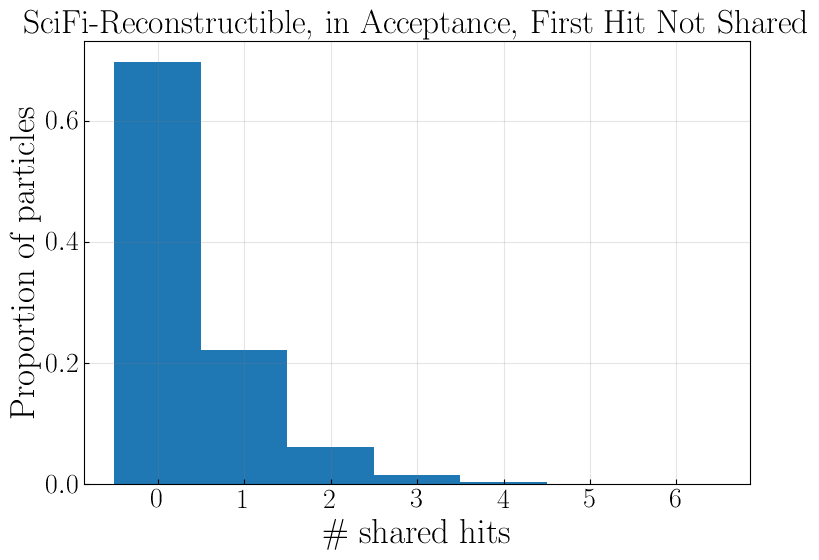

In [46]:
plot_n_shared_hits_per_particle(
    df_hits_particles_in_cat_fh[
       ~df_hits_particles_in_cat_fh["particle_whose_first_hit_is_shared"]
    ],
    title="SciFi-Reconstructible, in Acceptance, First Hit Not Shared",
    suffix="_scifi_in_acc_wo_first_shared_hit",
)

[6.47140297e-01 2.41441596e-01 7.91406970e-02 2.39599620e-02
 6.24701036e-03 1.52784025e-03 5.42597471e-04]
Figure was saved in /home/acorreia/Documents/tracking/etx4velo/etx4velo/output/preliminary/scifi/n_shared_hits_per_particle_scifi_in_acc_ge_9_planes.pdf
Figure was saved in /home/acorreia/Documents/tracking/etx4velo/etx4velo/output/preliminary/scifi/n_shared_hits_per_particle_scifi_in_acc_ge_9_planes.png


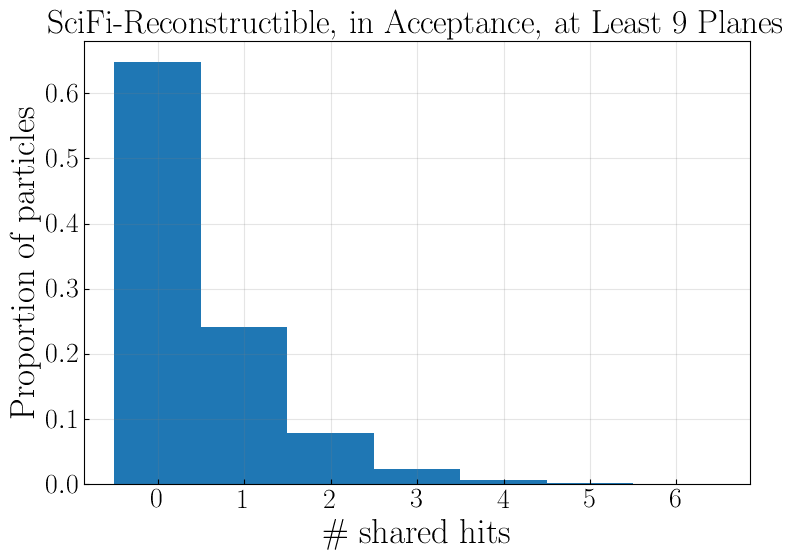

In [45]:
if "particle_n_planes" not in df_hits_particles_genuine_in_cat:
    df_hits_particles_genuine_in_cat = df_hits_particles_genuine_in_cat.merge(
        df_hits_particles_genuine_in_cat.groupby(["event_id", "particle_id"])["plane"]
        .nunique()
        .rename("particle_n_planes")
        .reset_index(),
        how="left",
        on=["event_id", "particle_id"],
    )

plot_n_shared_hits_per_particle(
    df_hits_particles_genuine_in_cat[
        df_hits_particles_genuine_in_cat["particle_n_planes"] >= 9
    ],
    title="SciFi-Reconstructible, in Acceptance, at Least 9 Planes",
    suffix="_scifi_in_acc_ge_9_planes",
)

Figure was saved in /home/acorreia/Documents/tracking/etx4velo/etx4velo/output/preliminary/scifi/n_shared_hits_per_particle_at_least_9_planes.pdf
Figure was saved in /home/acorreia/Documents/tracking/etx4velo/etx4velo/output/preliminary/scifi/n_shared_hits_per_particle_at_least_9_planes.png


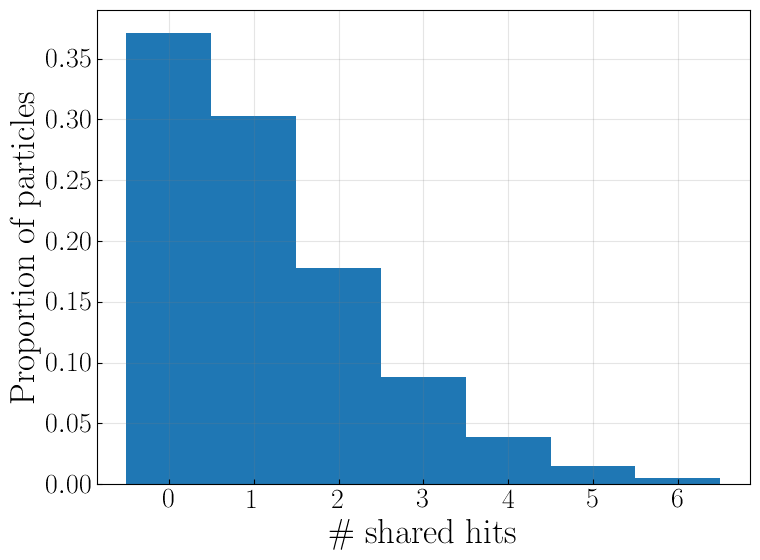

In [17]:
df_hits_particles_genuine_in_cat["at_least_9_planes"] = (
    df_hits_particles_genuine_in_cat["particle_n_planes"] >= 9
)

fig, ax = plt.subplots(figsize=(8, 6))

max_n_shared = 6

hist_n_shared_hits_per_particle, _ = np.histogram(
    df_hits_particles_genuine_in_cat[
        df_hits_particles_genuine_in_cat["at_least_9_planes"]
    ]
    .groupby(["event_id", "particle_id"])["shared"]
    .sum(),
    bins=np.arange(max_n_shared + 2) - 0.5,
)

ax.bar(
    x=np.arange(max_n_shared + 1),
    height=hist_n_shared_hits_per_particle / hist_n_shared_hits_per_particle.sum(),
    width=1.0,
)
ax.set_xticks(np.arange(max_n_shared + 1))
ax.set_xlabel("\\# shared hits")
ax.set_ylabel("Proportion of particles")
ax.grid(color="grey", alpha=0.2)

save_fig(fig, op.join(plotdir, "n_shared_hits_per_particle_at_least_9_planes"))

In [115]:
particles_grouped_by_plane = df_hits_particles_genuine_in_cat.groupby(
    ["particle_id", "event_id", "plane"]
)["hit_id"].count()

n_hits_per_particle = (
    particles_grouped_by_plane.groupby(["particle_id", "event_id"])
    .sum()
    .rename("n_hits_particle")
)
n_planes_per_particle = particles_grouped_by_plane.groupby(
    ["particle_id", "event_id"]
).count().rename("n_planes_particle")


Figure was saved in /home/acorreia/Documents/tracking/etx4velo/etx4velo/output/preliminary/scifi/n_hits_on_same_plane_per_particle.pdf
Figure was saved in /home/acorreia/Documents/tracking/etx4velo/etx4velo/output/preliminary/scifi/n_hits_on_same_plane_per_particle.png


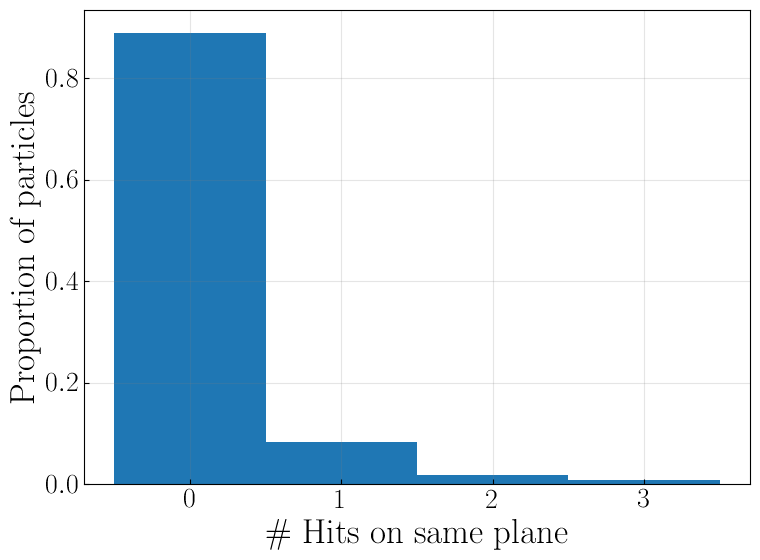

In [118]:
fig, ax = plt.subplots(figsize=(8, 6))

max_n_hits_on_same_plane = 3

hist_n_hits_on_same_plane, _ = np.histogram(
    n_hits_per_particle - n_planes_per_particle,
    bins=np.arange(max_n_hits_on_same_plane + 2) - 0.5,
)
ax.bar(
    x=np.arange(max_n_hits_on_same_plane + 1),
    height=hist_n_hits_on_same_plane / hist_n_hits_on_same_plane.sum(),
    width=1.0,
)
ax.set_xlabel("\\# Hits on same plane")
ax.set_ylabel("Proportion of particles")
ax.grid(color="grey", alpha=0.2)
ax.locator_params(axis="x", integer=True)

save_fig(fig, op.join(plotdir, "n_hits_on_same_plane_per_particle"))

# Edges-related distributions

The edges are build plane by plane

In [134]:
max_plane_diff = 4
bin_centers = np.arange(1, max_plane_diff + 1)
bin_edges = np.arange(1, max_plane_diff + 2) - 0.5

grouped_df_hits = df_hits.groupby("event_id")


def get_hist_plane_diff(df_hits_particles_event: pd.DataFrame, event_id: int):
    df_hits_particles_event["index"] = df_hits_particles_event["hit_id"]

    edge_indices = get_planewise_edges(hits=df_hits_particles_event)

    df_edges = pd.DataFrame(
        {
            "hit_id_left": edge_indices[0],
            "hit_id_right": edge_indices[1],
        }
    ).drop_duplicates()

    # Add plane information
    df_hits_event = grouped_df_hits.get_group(event_id)
    for side in ("left", "right"):
        df_edges = df_edges.merge(
            df_hits_event.rename(
                columns={column: f"{column}_{side}" for column in df_hits_event.columns}
            ),
            on=f"hit_id_{side}",
            how="left",
        )

    assert not df_edges.duplicated(["hit_id_left", "hit_id_right"], keep=False).any()

    plane_diff = df_edges["plane_right"] - df_edges["plane_left"]
    plane_diff_hist, _ = np.histogram(plane_diff, bins=bin_edges, density=False)

    return plane_diff_hist


list_plane_diff_hists: typing.List[npt.NDArray] = Parallel(n_jobs=1)(  # type: ignore
    delayed(get_hist_plane_diff)(df_hits_particles_event, event_id)
    for event_id, df_hits_particles_event in tqdm(df_hits_particles.groupby("event_id"))
)

plane_diff_hist: npt.NDArray = sum(list_plane_diff_hists)  # type: ignore


  0%|          | 0/1171 [00:00<?, ?it/s]

Figure was saved in /home/acorreia/Documents/tracking/etx4velo/etx4velo/output/preliminary/scifi/hist_edge_plane_diff.pdf
Figure was saved in /home/acorreia/Documents/tracking/etx4velo/etx4velo/output/preliminary/scifi/hist_edge_plane_diff.png


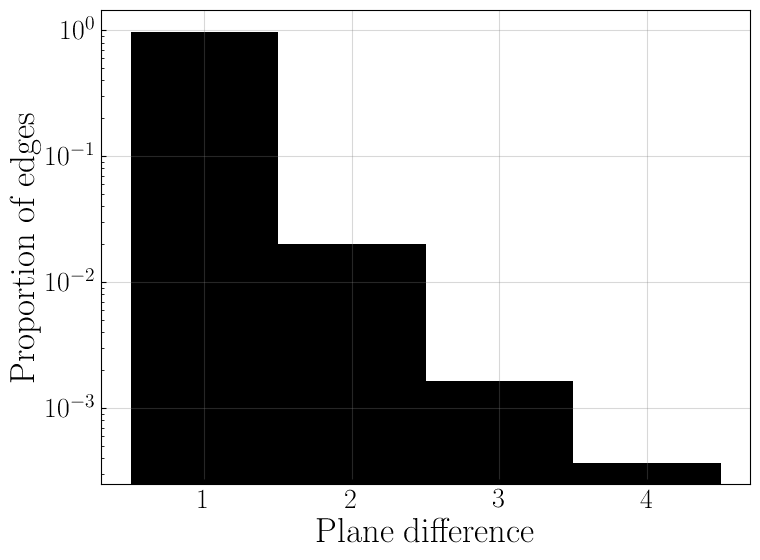

In [137]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlabel("Plane difference")
ax.set_yscale("log")
ax.set_ylabel("Proportion of edges")
ax.bar(
    x=bin_centers,
    height=plane_diff_hist / plane_diff_hist.sum(),
    width=1.0,
    color="k",
)
ax.locator_params(axis="x", integer=True)
ax.grid(color="grey", alpha=0.3)
save_fig(fig, op.join(plotdir, "hist_edge_plane_diff"))


# Tracks


In [139]:
df_hits_particles

17207281001911841

In [72]:
from numpy.polynomial.polynomial import Polynomial


def plot_xz_graph(
    df_hits_particles: pd.DataFrame,
    n_tracks: int,
    n_events: int = 10,
    seed: int | None = None,
    remove_tilted: bool = True,
    polyfit: bool = False,
):
    fig, ax = plt.subplots(figsize=(8, 6))

    event_ids = df_hits_particles["event"].unique()

    rng = np.random.default_rng(seed=seed)
    rng.shuffle(event_ids)

    if remove_tilted:
        df_hits_particles = df_hits_particles[df_hits_particles["dxdy"] == 0.0]

    for idx, (_, hits_particle) in enumerate(
        df_hits_particles[
            df_hits_particles["event"].isin(event_ids[:n_events])
            & df_hits_particles["particle_id"]
            != 0
        ].groupby(by=["event", "particle_id"])
    ):
        hit_coordinates = hits_particle.sort_values(by="plane")

        lines = ax.plot(
            hit_coordinates["zatyeq0"],
            hit_coordinates["xatyeq0"],
            linestyle="" if polyfit else "-",
            markersize=5.0,
            marker="o",
        )
        if polyfit:
            not_tilted_hit_coordinates = hit_coordinates[hit_coordinates["dxdy"] == 0.0]
            polynomial = Polynomial.fit(
                x=not_tilted_hit_coordinates["zatyeq0"],
                y=not_tilted_hit_coordinates["xatyeq0"],
                deg=2,
            )
            ax.plot(
                *polynomial.linspace(
                    n=100,
                    domain=[
                        hit_coordinates["zatyeq0"].min(),
                        hit_coordinates["zatyeq0"].max(),
                    ],
                ),
                linestyle="--",
                color=lines[0].get_color(),
            )
            
        print(hit_coordinates[["zatyeq0", "zatyeq0", "plane"]])

        if idx > n_tracks:
            break

    ax.set_xlabel("z")
    ax.set_ylabel("x")
    ax.set_xlim(
        (
            df_hits_particles["zatyeq0"].min() - 100,
            df_hits_particles["zatyeq0"].max() + 100,
        )
    )
    ax.set_ylim(
        (df_hits_particles["xatyeq0"].min(), df_hits_particles["xatyeq0"].max())  # type: ignore
    )
    return fig

In [32]:
df_hits_particles_augmented = df_hits_particles.merge(
    df_particles[
        ["event_id", "particle_id", "pt", "p", "nhits_scifi", "has_scifi", "eta"]
    ],
    how="left",
    on=["event_id", "particle_id"],
)

(array([24204., 21184., 24836., 19406., 14047., 10957.,  8521.,  6851.,
         5894.,  4878.]),
 array([    0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,  7000.,
         8000.,  9000., 10000.]),
 <BarContainer object of 10 artists>)

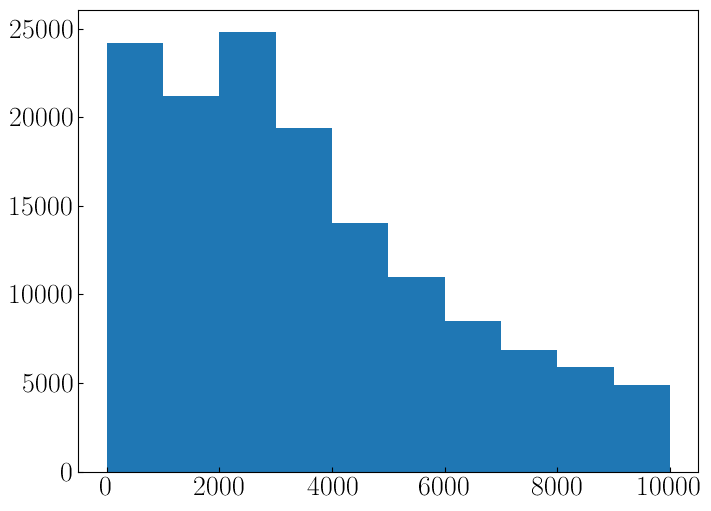

In [21]:
plt.hist(df_particles[df_particles["has_scifi"]]["p"], range=(0,10000))

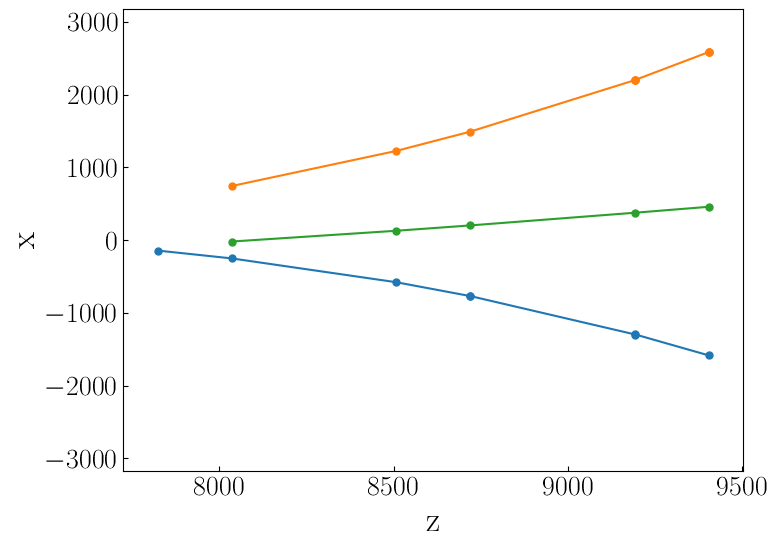

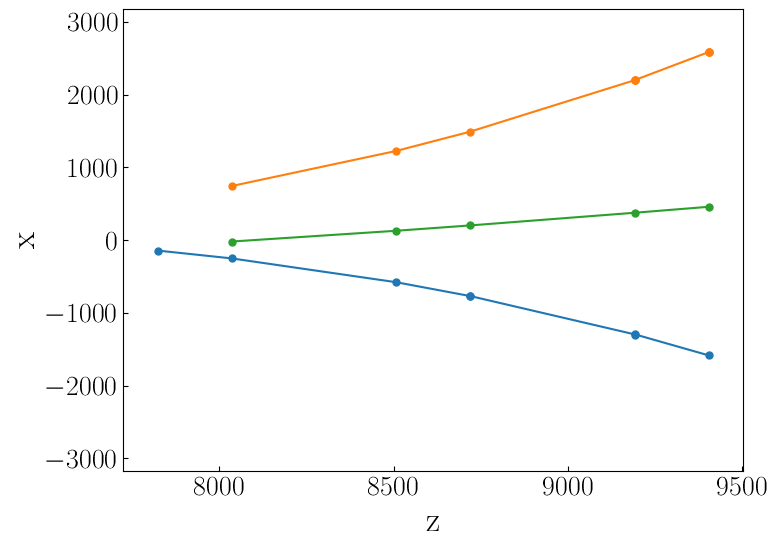

In [33]:
plot_xz_graph(
    df_hits_particles=df_hits_particles_augmented[
        df_hits_particles_augmented["has_scifi"]
        & (df_hits_particles_augmented["nhits_scifi"] < 1000)
    ],
    n_tracks=100,
    n_events=1,
)

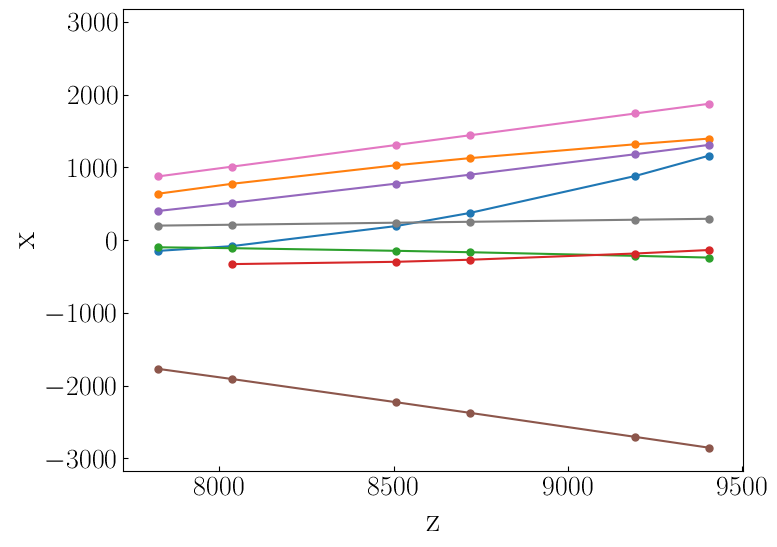

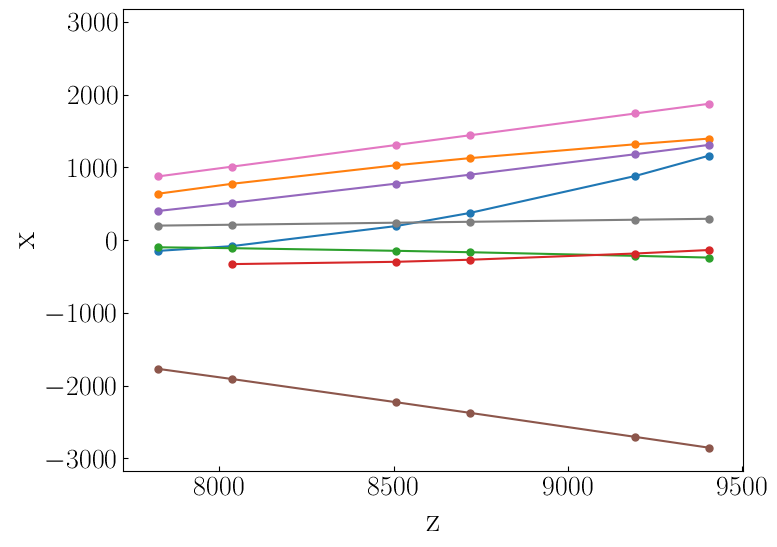

In [34]:
plot_xz_graph(
    df_hits_particles=df_hits_particles_augmented[
        df_hits_particles_augmented["has_scifi"]
        & (~mtb.category.in_acceptance.mask(df_hits_particles_augmented))
    ],
    n_tracks=100,
    n_events=1,
)

In [ ]:
df_hits_particles.groupby(["event_id", "particle_id", "plane"])

In [41]:
df_hits_particles_augmented = df_hits_particles_augmented.merge(
    df_hits_particles_augmented.groupby(["event_id", "particle_id"])["hit_id"]
    .count()
    .rename("n_hits_particle")
    .reset_index(),
    how="left",
    on=["event_id", "particle_id"],
)

In [117]:
gb = iter(
    df_hits_particles_augmented[
        (df_hits_particles_augmented["n_hits_particle"] > 40)
        & (df_hits_particles_augmented["has_scifi"])
    ].groupby(["run", "event_id"])
)

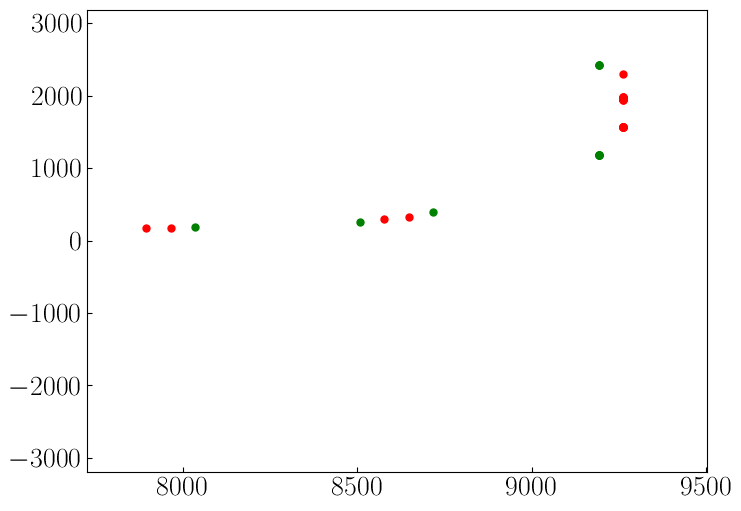

In [139]:
_, hit_coordinates = next(gb)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(
    hit_coordinates[hit_coordinates["dxdy"] == 0]["zatyeq0"],
    hit_coordinates[hit_coordinates["dxdy"] == 0]["xatyeq0"],
    markersize=5.0,
    marker="o",
    color="g",
    linestyle="",
)

ax.plot(
    hit_coordinates[hit_coordinates["dxdy"] != 0]["zatyeq0"],
    hit_coordinates[hit_coordinates["dxdy"] != 0]["xatyeq0"],
    markersize=5.0,
    marker="o",
    color="r",
    linestyle="",
)
ax.set_xlim(
    (
        df_hits_particles["zatyeq0"].min() - 100,
        df_hits_particles["zatyeq0"].max() + 100,
    )
)
ax.set_ylim(
    (df_hits_particles["xatyeq0"].min(), df_hits_particles["xatyeq0"].max())  # type: ignore
)
fig.show()
# print(hit_coordinates)

In [136]:
hit_coordinates[hit_coordinates["plane"] == 0]

run    event  plane  xatyeq0  zatyeq0  dxdy      dzdy  weight  \
1496987  17207109  1882966      0   12.140   7826.1  -0.0  0.003601   400.0   
1496989  17207109  1882966      0   13.140   7826.1  -0.0  0.003601   400.0   
1496991  17207109  1882966      0   14.140   7826.1  -0.0  0.003601   400.0   
1496993  17207109  1882966      0   15.140   7826.1  -0.0  0.003601   400.0   
1496995  17207109  1882966      0   16.140   7826.1  -0.0  0.003601   400.0   
1496997  17207109  1882966      0   17.140   7826.1  -0.0  0.003601   400.0   
1497000  17207109  1882966      0   18.140   7826.1  -0.0  0.003601   400.0   
1497004  17207109  1882966      0   19.140   7826.1  -0.0  0.003601   400.0   
1497007  17207109  1882966      0   20.360   7826.1  -0.0  0.003601   400.0   
1497009  17207109  1882966      0   21.360   7826.1  -0.0  0.003601   400.0   
1497011  17207109  1882966      0   22.360   7826.1  -0.0  0.003601   400.0   
1497013  17207109  1882966      0   23.360   7826.1  -0.0  0.003601   400.0   
1497015  17207109  1882966      0   24.360   7826.1  -0.0  0.003601   400.0   
1497017  17207109  1882966      0   25.360   7826.1  -0.0  0.003601   400.0   
1497019  17207109  1882966      0   26.360   7826.1  -0.0  0.003601   400.0   
1497021  17207109  1882966      0   27.360   7826.1  -0.0  0.003601   400.0   
1497023  17207109  1882966      0   28.360   7826.1  -0.0  0.003601   400.0   
1497025  17207109  1882966      0   29.360   7826.1  -0.0  0.003601   400.0   
1497028  17207109  1882966      0   30.360   7826.1  -0.0  0.003601   400.0   
1497031  17207109  1882966      0   31.360   7826.1  -0.0  0.003601   400.0   
1497032  17207109  1882966      0   32.360   7826.1  -0.0  0.003601   400.0   
1497033  17207109  1882966      0   33.360   7826.1  -0.0  0.003601   400.0   
1497034  17207109  1882966      0   34.360   7826.1  -0.0  0.003601   400.0   
1497035  17207109  1882966      0   35.360   7826.1  -0.0  0.003601   400.0   
1497036  17207109  1882966      0   36.715   7826.1  -0.0  0.003601   400.0   
1497037  17207109  1882966      0   37.590   7826.1  -0.0  0.003601   400.0   
1497038  17207109  1882966      0   38.590   7826.1  -0.0  0.003601   400.0   
1497039  17207109  1882966      0   39.590   7826.1  -0.0  0.003601   400.0   
1497041  17207109  1882966      0   40.590   7826.1  -0.0  0.003601   400.0   
1497043  17207109  1882966      0   41.590   7826.1  -0.0  0.003601   400.0   
1497045  17207109  1882966      0   42.590   7826.1  -0.0  0.003601   400.0   
1497047  17207109  1882966      0   43.590   7826.1  -0.0  0.003601   400.0   
1497048  17207109  1882966      0   44.590   7826.1  -0.0  0.003601   400.0   
1497050  17207109  1882966      0   45.590   7826.1  -0.0  0.003601   400.0   
1497052  17207109  1882966      0   46.590   7826.1  -0.0  0.003601   400.0   
1497053  17207109  1882966      0   47.590   7826.1  -0.0  0.003601   400.0   
1497054  17207109  1882966      0   48.590   7826.1  -0.0  0.003601   400.0   
1497055  17207109  1882966      0   49.590   7826.1  -0.0  0.003601   400.0   
1497056  17207109  1882966      0   50.590   7826.1  -0.0  0.003601   400.0   
1497057  17207109  1882966      0   51.590   7826.1  -0.0  0.003601   400.0   
1497058  17207109  1882966      0   52.810   7826.1  -0.0  0.003601   400.0   

             hit_id           event_id  particle_id   fake  min_plane  \
1496987  1342490589  17207109001882966         1247  False          0   
1496989  1342490585  17207109001882966         1247  False          0   
1496991  1342490581  17207109001882966         1247  False          0   
1496993  1342490577  17207109001882966         1247  False          0   
1496995  1342490573  17207109001882966         1247  False          0   
1496997  1342490569  17207109001882966         1247  False          0   
1497000  1342490565  17207109001882966         1247  False          0   
1497004  1342490561  17207109001882966         1247  False          0   
1497007  1342490557  17207109001882966

         zatyeq0  zatyeq0  plane
3043636   7895.9   7895.9      1
3044587   7966.1   7966.1      2
3045537   8035.9   8035.9      3
3046416   8508.1   8508.1      4
3047348   8577.9   8577.9      5
...          ...      ...    ...
3052449   9333.1   9333.1     10
3052450   9333.1   9333.1     10
3052451   9333.1   9333.1     10
3052453   9333.1   9333.1     10
3052485   9333.1   9333.1     10

[75 rows x 3 columns]
         zatyeq0  zatyeq0  plane
1482940   7826.1   7826.1      0
1483204   7895.9   7895.9      1
1483444   7966.1   7966.1      2
1483712   8035.9   8035.9      3
1483780   8508.1   8508.1      4
1483799   8508.1   8508.1      4
1483967   8508.1   8508.1      4
1484234   8577.9   8577.9      5
1484053   8577.9   8577.9      5
1484052   8577.9   8577.9      5
1484045   8577.9   8577.9      5
1484534   8648.1   8648.1      6
1484820   8717.9   8717.9      7
1484913   9193.1   9193.1      8
1485100   9193.1   9193.1      8
1485101   9193.1   9193.1      8
1485102   9193.1   9

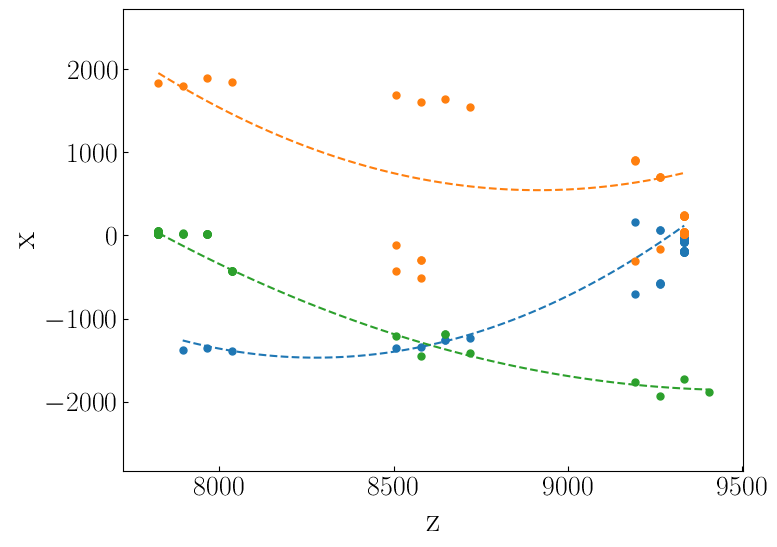

In [73]:
plot_xz_graph(
    df_hits_particles=df_hits_particles_augmented[
        df_hits_particles_augmented["has_scifi"]
        & (df_hits_particles_augmented["n_hits_particle"] > 50)
    ],
    n_tracks=1,
    n_events=50,
    remove_tilted=False,
    polyfit=True,
);

In [ ]:
plot_xz_graph(
    df_hits_particles=df_hits_particles_augmented[
        df_hits_particles_augmented["n_hits_particle"]
        & (df_hits_particles_augmented["n_hits_particle"] > 15)
    ],
    n_tracks=5,
    n_events=50,
    remove_tilted=False,
    
);

## Cut on distance to line

In [186]:
from Preprocessing.particle_fitting_metrics import compute_particle_line_metrics_dataframe

In [193]:
new_distances = compute_particle_line_metrics_dataframe(
    hits=df_hits_particles[df_hits_particles["dxdy"] == 0],
    metric_names=["distance_to_line"],
)

KeyError: "None of [Index(['x', 'y', 'z'], dtype='object')] are in the [columns]"

In [192]:
df_hits_particles

run    event  plane  xatyeq0  zatyeq0  dxdy      dzdy    weight  \
0        17215691  3324721      0 -2628.51   7826.1   0.0  0.003601   34.6021   
1        17215691  3324721      0 -2585.31   7826.1   0.0  0.003601   34.6021   
2        17215691  3324721      0 -2571.21   7826.1   0.0  0.003601   34.6021   
3        17215691  3324721      0 -2488.21   7826.1   0.0  0.003601   34.6021   
4        17215691  3324721      0 -2308.11   7826.1   0.0  0.003601   34.6021   
...           ...      ...    ...      ...      ...   ...       ...       ...   
5015139  17224051  4729368     11  2773.08   9402.9  -0.0  0.003601   34.6021   
5015140  17224051  4729368     11  2792.19   9402.9  -0.0  0.003601  400.0000   
5015141  17224051  4729368     11  2793.19   9402.9  -0.0  0.003601  400.0000   
5015142  17224051  4729368     11  2794.19   9402.9  -0.0  0.003601  400.0000   
5015143  17224051  4729368     11  2897.92   9402.9  -0.0  0.003601   34.6021   

             hit_id           event_id  particle_id  fake  
0        1342447686  17215691003324721            0  True  
1        1342447856  17215691003324721            0  True  
2        1342447910  17215691003324721            0  True  
3        1342448236  17215691003324721            0  True  
4        1342448940  17215691003324721            0  True  
...             ...                ...          ...   ...  
5015139  1343220180  17224051004729368            0  True  
5015140  1343220254  17224051004729368            0  True  
5015141  1343220258  17224051004729368            0  True  
5015142  1343220262  17224051004729368            0  True  
5015143  1343220669  17224051004729368            0  True  

[5015144 rows x 12 columns]

# Feature means

==== xatyeq0 ====
mean: -23.518647256579285
std: 1276.9142562968793
==== zatyeq0 ====
mean: 8632.55048110284
std: 569.9569372627293
==== dxdy ====
mean: -0.00043464223918595354
std: 0.061898412360019125


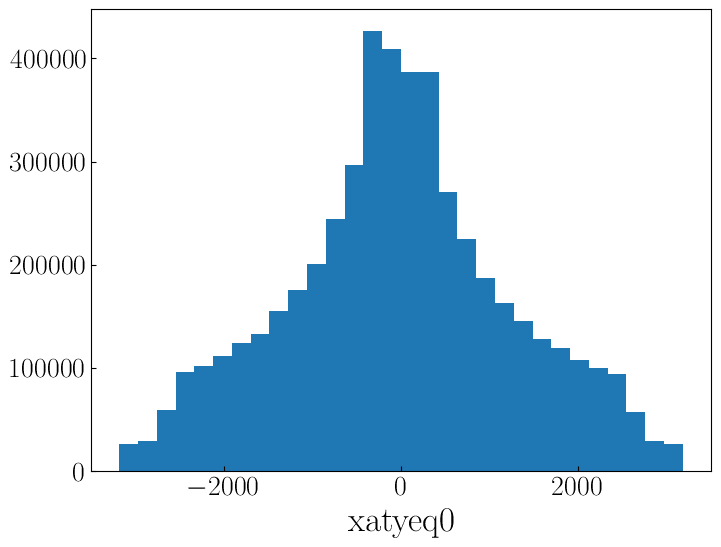

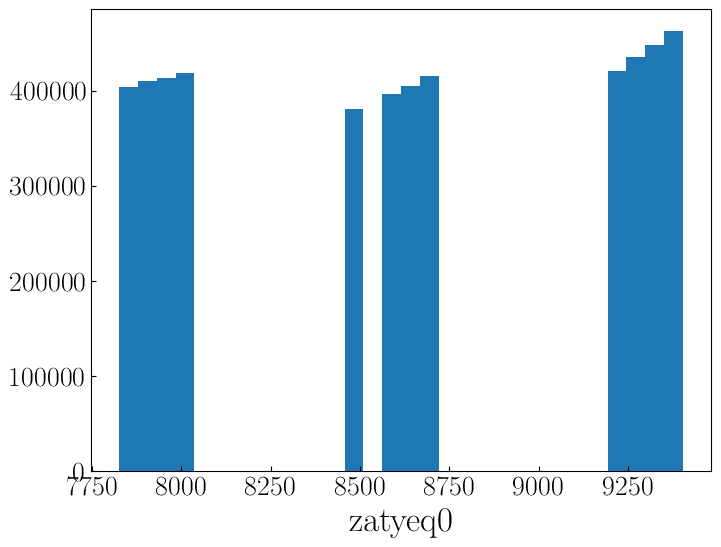

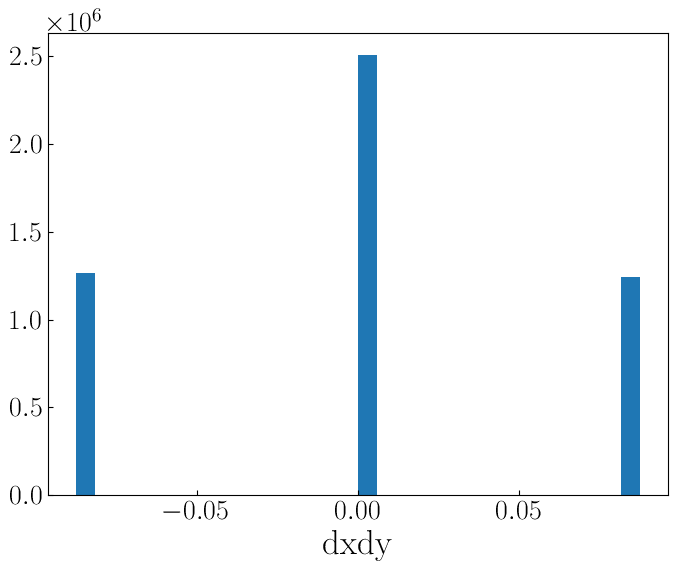

In [200]:
for column in ["xatyeq0", "zatyeq0", "dxdy"]:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.hist(df_hits_particles[column], bins=30)
    ax.set_xlabel(column)
    print("====", column, "====")
    print("mean:", df_hits_particles[column].mean())
    print("std:", df_hits_particles[column].std())

# Best Results

## Edge-Only


## Edge + Triplets